# F1 Race Outcome Predictor

**Sections**
1. Setup & environment check
2. Download dataset from Kaggle
3. Load CSVs
4. Inspect & normalize columns
5. Merge results + qualifying
6. Attach race metadata (season/round)
7. Map statusId → status (optional)
8. Define finished cars & create podium label
9. Save processed dataset
10. Baseline model & evaluation
11. Quick visualization

## Load Libraries

In [2]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import os, pathlib
from pathlib import Path

import time
import requests
import shutil

import random
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry



In [3]:
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

print("Current working dir:", os.getcwd())

Current working dir: /Users/tsuzumi.sato/f1-race-outcome-predictor


In [4]:
print(os.getcwd())

/Users/tsuzumi.sato/f1-race-outcome-predictor


In [5]:

PROJECT = Path.cwd()
RAW = PROJECT / "data" / "raw"
print("PROJECT:", PROJECT)
print("RAW dir exists? ", RAW.exists(), RAW)

# List what's in data/raw (if it exists)
print("\n-- data/raw contents --")
print([p.name for p in RAW.glob("*")])

# Try common alternate locations (e.g., saved under notebooks/)
ALT = PROJECT / "notebooks" / "data" / "raw"
print("\nALT dir exists? ", ALT.exists(), ALT)
print([p.name for p in ALT.glob("*")] if ALT.exists() else "ALT not found")

# Also list any CSVs named like races/results/qualifying anywhere in project
print("\n-- any likely CSVs in project --")
candidates = list(PROJECT.rglob("races*.csv")) + list(PROJECT.rglob("results*.csv")) + list(PROJECT.rglob("qualifying*.csv"))
for c in candidates[:20]:
    print(c)


PROJECT: /Users/tsuzumi.sato/f1-race-outcome-predictor
RAW dir exists?  True /Users/tsuzumi.sato/f1-race-outcome-predictor/data/raw

-- data/raw contents --
['circuits.csv', 'status.csv', 'lap_times.csv', 'drivers.csv', 'races.csv', 'constructors.csv', 'qualifying.csv', 'pit_stops.csv', 'results.csv']

ALT dir exists?  True /Users/tsuzumi.sato/f1-race-outcome-predictor/notebooks/data/raw
['sprint_results.csv', 'constructor_standings.csv', 'driver_standings.csv', 'constructor_results.csv', 'seasons.csv']

-- any likely CSVs in project --
/Users/tsuzumi.sato/f1-race-outcome-predictor/data/raw/races.csv
/Users/tsuzumi.sato/f1-race-outcome-predictor/data/raw/results.csv
/Users/tsuzumi.sato/f1-race-outcome-predictor/data/raw/qualifying.csv


In [6]:

PROJECT = Path.cwd()
SRC = PROJECT / "notebooks" / "data" / "raw"
DST = PROJECT / "data" / "raw"
DST.mkdir(parents=True, exist_ok=True)

moved = []
for name in ["races.csv", "results.csv", "qualifying.csv", "status.csv", "drivers.csv", "constructors.csv", "circuits.csv", "lap_times.csv", "pit_stops.csv"]:
    src = SRC / name
    if src.exists():
        shutil.move(str(src), DST / name)
        moved.append(name)

print("Moved:", moved)
print("Now in data/raw:", [p.name for p in DST.glob("*")])

Moved: []
Now in data/raw: ['circuits.csv', 'status.csv', 'lap_times.csv', 'drivers.csv', 'races.csv', 'constructors.csv', 'qualifying.csv', 'pit_stops.csv', 'results.csv']


## 1) Setup & environment check

In [7]:
!which python
!python -V

# %pip install pandas scikit-learn matplotlib kaggle python-dotenv

import pandas as pd, numpy as np
from pathlib import Path
print('Pandas:', pd.__version__)

/Users/tsuzumi.sato/f1-race-outcome-predictor/.venv/bin/python
Python 3.11.13
Pandas: 2.2.2


## 2) (Optional) Download dataset from Kaggle
Set your dataset slug (e.g., `rohanrao/formula-1-world-championship-1950-2020`).
Your Kaggle token must be at `~/.kaggle/kaggle.json` with `chmod 600`.

In [8]:
KAGGLE_DATASET = 'rohanrao/formula-1-world-championship-1950-2020'  # e.g., 'rohanrao/formula-1-world-championship-1950-2020'
RAW_DIR = Path('data/raw'); RAW_DIR.mkdir(parents=True, exist_ok=True)

if KAGGLE_DATASET:
    # %pip install kaggle
    import sys, subprocess
    print('Downloading to', RAW_DIR.resolve())
    subprocess.run([sys.executable,'-m','kaggle','datasets','download','-d',KAGGLE_DATASET,'-p',str(RAW_DIR),'--unzip'], check=False)
else:
    print('Skip: set KAGGLE_DATASET or place CSVs under data/raw/.')

/Users/tsuzumi.sato/f1-race-outcome-predictor/.venv/bin/python: No module named kaggle.__main__; 'kaggle' is a package and cannot be directly executed


In [9]:
print(os.getcwd())

/Users/tsuzumi.sato/f1-race-outcome-predictor


## 3) Load CSVs
Load `races.csv`, `results.csv`, `qualifying.csv` from `data/raw/`.

In [10]:
RAW_DIR = Path('data/raw')

races = pd.read_csv(RAW_DIR/'races.csv')
results = pd.read_csv(RAW_DIR/'results.csv')
qualifying = pd.read_csv(RAW_DIR/'qualifying.csv')

display(races.head(3), results.head(3), qualifying.head(3))

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1


,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3
0,1,18,1,1,22,1,1:26.572,1:25.187,1:26.714
1,2,18,9,2,4,2,1:26.103,1:25.315,1:26.869
2,3,18,5,1,23,3,1:25.664,1:25.452,1:27.079


## 4) Inspect & normalize columns
Rename `year` → `season` if needed; normalize IDs (driverid→driverId, etc.).

In [11]:
print('Races:', list(races.columns))
print('Results:', list(results.columns))
print('Qualifying:', list(qualifying.columns))

if 'year' in races.columns:
    races = races.rename(columns={'year': 'season'})

def normalize_ids(df):
    m = {}
    for c in df.columns:
        lc = c.lower()
        if lc=='driverid' and 'driverId' not in df.columns: m[c]='driverId'
        if lc=='constructorid' and 'constructorId' not in df.columns: m[c]='constructorId'
        if lc=='raceid' and 'raceId' not in df.columns: m[c]='raceId'
    return df.rename(columns=m)

races = normalize_ids(races)
results = normalize_ids(results)
qualifying = normalize_ids(qualifying)


Races: ['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time']
Results: ['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid', 'position', 'positionText', 'positionOrder', 'points', 'laps', 'time', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'statusId']
Qualifying: ['qualifyId', 'raceId', 'driverId', 'constructorId', 'number', 'position', 'q1', 'q2', 'q3']


## 5) Merge results + qualifying
Build a base table keyed by `(raceId, driverId)`; safely cast `grid`/`position` to ints.

In [12]:
results_cols = ['raceId', 'driverId', 'constructorId', 'grid', 'position', 'points']
if 'statusId' in results.columns:
    results_cols.insert(5, 'statusId')
r = results[results_cols].copy()

q = qualifying[['raceId', 'driverId', 'position']].copy()
q = q.rename(columns={'position': 'grid_quali'})

def to_int(x):
    try: return int(x)
    except: return None
r['grid'] = r['grid'].apply(to_int)
r['position'] = r['position'].apply(to_int)

df = r.merge(q, on=['raceId', 'driverId'], how='left')
df.head()

,raceId,driverId,constructorId,grid,position,statusId,points,grid_quali
0,18,1,1,1,1.0,1,10.0,1.0
1,18,2,2,5,2.0,1,8.0,5.0
2,18,3,3,7,3.0,1,6.0,7.0
3,18,4,4,11,4.0,1,5.0,12.0
4,18,5,1,3,5.0,1,4.0,3.0


## 6) Attach race metadata (season/round)
Merge **on `raceId` only** to add `season`, `round`, `name`, `date`, `circuitId`.

In [13]:
races.columns

Index(['raceId', 'season', 'round', 'circuitId', 'name', 'date', 'time', 'url',
       'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time',
       'quali_date', 'quali_time', 'sprint_date', 'sprint_time'],
      dtype='object')

In [14]:


race_meta = races[['raceId', 'season', 'round', 'name', 'date', 'circuitId']].copy()
df = df.merge(race_meta, on='raceId', how='left')
df.head()

,raceId,driverId,constructorId,grid,position,statusId,points,grid_quali,season,round,name,date,circuitId
0,18,1,1,1,1.0,1,10.0,1.0,2008,1,Australian Grand Prix,2008-03-16,1
1,18,2,2,5,2.0,1,8.0,5.0,2008,1,Australian Grand Prix,2008-03-16,1
2,18,3,3,7,3.0,1,6.0,7.0,2008,1,Australian Grand Prix,2008-03-16,1
3,18,4,4,11,4.0,1,5.0,12.0,2008,1,Australian Grand Prix,2008-03-16,1
4,18,5,1,3,5.0,1,4.0,3.0,2008,1,Australian Grand Prix,2008-03-16,1


## 7) Map statusId → status (optional)
If `status.csv` exists, map `statusId` → `status` and merge.

In [15]:
status_path = Path('data/raw/status.csv')
if status_path.exists() and 'statusId' in df.columns:
    status_map = pd.read_csv(status_path)[['statusId', 'status']]
    df = df.merge(status_map, on='statusId', how = 'left')
df.head()

,raceId,driverId,constructorId,grid,position,statusId,points,grid_quali,season,round,name,date,circuitId,status
0,18,1,1,1,1.0,1,10.0,1.0,2008,1,Australian Grand Prix,2008-03-16,1,Finished
1,18,2,2,5,2.0,1,8.0,5.0,2008,1,Australian Grand Prix,2008-03-16,1,Finished
2,18,3,3,7,3.0,1,6.0,7.0,2008,1,Australian Grand Prix,2008-03-16,1,Finished
3,18,4,4,11,4.0,1,5.0,12.0,2008,1,Australian Grand Prix,2008-03-16,1,Finished
4,18,5,1,3,5.0,1,4.0,3.0,2008,1,Australian Grand Prix,2008-03-16,1,Finished


## 8) Define finished cars & podium label
Create `finished_mask`, then `podium = (position <= 3)`.

In [16]:
df['position'] = pd.to_numeric(df['position'], errors='coerce')
if 'status' in df.columns:
    pat = r'Finished|\+\d+\s*Lap'
    finished_mask = df['status'].astype(str).str.contains(pat, case=False, na=False)
else:
    finished_mask = df['position'].notna()
df_baseline = df[finished_mask].copy()
df_baseline['podium'] = (df_baseline['position'] <= 3).astype(int)
df_baseline[['season', 'round', 'name', 'driverId', 'grid', 'position', 'podium']].head()


,season,round,name,driverId,grid,position,podium
0,2008,1,Australian Grand Prix,1,1,1.0,1
1,2008,1,Australian Grand Prix,2,5,2.0,1
2,2008,1,Australian Grand Prix,3,7,3.0,1
3,2008,1,Australian Grand Prix,4,11,4.0,0
4,2008,1,Australian Grand Prix,5,3,5.0,0


## Weather cell A

In [17]:
# RAW already defined earlier in your notebook setup
EXTERNAL = Path("data/external")
EXTERNAL.mkdir(parents=True, exist_ok=True)

# --- circuits: ensure circuitId, latitude, longitude ---
circuits_raw = pd.read_csv(RAW / "circuits.csv").copy()
clower = {c.lower(): c for c in circuits_raw.columns}

def _pick(d, *names):
    for n in names:
        if n in d:
            return d[n]
    return None

cid = _pick(clower, "circuitid")
latc = _pick(clower, "lat", "latitude")
lonc = _pick(clower, "lng", "long", "longitude")
if cid is None or latc is None or lonc is None:
    raise ValueError("circuits.csv must include circuitId + lat/lon columns")

circuits = circuits_raw.rename(columns={cid:"circuitId", latc:"latitude", lonc:"longitude"})
circuits = circuits[["circuitId","latitude","longitude"]].copy()

# --- races: ensure raceId, circuitId, date (and season/round if present) ---
races_raw = pd.read_csv(RAW / "races.csv").copy()
if "year" in races_raw.columns and "season" not in races_raw.columns:
    races_raw = races_raw.rename(columns={"year": "season"})

keep = [c for c in ["raceId","circuitId","season","round","date","time"] if c in races_raw.columns]
races_norm = races_raw[keep].copy()
races_norm["raceId"]    = pd.to_numeric(races_norm["raceId"], errors="coerce").astype("Int64")
races_norm["circuitId"] = pd.to_numeric(races_norm["circuitId"], errors="coerce").astype("Int64")
races_norm["date"]      = pd.to_datetime(races_norm["date"], errors="coerce")

## Weather Cell B

In [18]:
def fetch_openmeteo_daily(lat, lon, date_str, session=None, model=None):
    """
    Fetch daily weather aggregates for one date & lat/lon using Open-Meteo historical API.
    Returns dict or None.
    """
    base = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": f"{lat:.4f}",
        "longitude": f"{lon:.4f}",
        "start_date": date_str,
        "end_date": date_str,
        "timezone": "auto",              # required for daily outputs
        "temperature_unit": "celsius",
        "wind_speed_unit": "kmh",
        "precipitation_unit": "mm",
        "daily": ",".join([
            "temperature_2m_mean",
            "temperature_2m_max",
            "precipitation_sum",
            "rain_sum",
            "windspeed_10m_max",
            "windgusts_10m_max",
            "relative_humidity_2m_mean",
            "cloud_cover_mean",
        ])
    }
    if model:
        params["models"] = model  # optional: "era5"

    s = session or requests.Session()
    r = s.get(base, params=params, timeout=20)
    r.raise_for_status()
    j = r.json()
    d = j.get("daily", {})
    if not d or not d.get("time"):
        return None

    out = {
        "date": d["time"][0],
        "wx_temp_mean_c": d.get("temperature_2m_mean", [np.nan])[0],
        "wx_temp_max_c":  d.get("temperature_2m_max",  [np.nan])[0],
        "wx_precip_mm":   d.get("precipitation_sum",   [np.nan])[0],
        "wx_rain_mm":     d.get("rain_sum",           [np.nan])[0],
        "wx_windspeed_max_kmh": d.get("windspeed_10m_max", [np.nan])[0],
        "wx_windgusts_max_kmh": d.get("windgusts_10m_max", [np.nan])[0],
        "wx_rh_mean_pct":      d.get("relative_humidity_2m_mean", [np.nan])[0],
        "wx_cloud_mean_pct":   d.get("cloud_cover_mean",           [np.nan])[0],
    }
    out["wx_is_wet"] = int((out["wx_precip_mm"] or 0) > 0.0)
    out["wx_is_hot"] = int((out["wx_temp_max_c"] or -273) >= 30)
    return out


## Weather Cell C

In [19]:
def make_session_with_retries():
    s = requests.Session()
    # Be a good citizen: identify your app
    s.headers.update({"User-Agent": "f1-outcome-model/1.0 (+educational use)"})
    retry = Retry(
        total=6,              # overall cap per request
        read=6,
        connect=6,
        backoff_factor=1.2,   # 1.2s, 2.4s, 4.8s, ...
        status_forcelist=(429, 500, 502, 503, 504),
        allowed_methods=frozenset(["GET"])  # only GETs
    )
    adapter = HTTPAdapter(max_retries=retry, pool_connections=20, pool_maxsize=20)
    s.mount("https://", adapter)
    s.mount("http://", adapter)
    return s

def get_json_with_backoff(session: requests.Session, url: str, params: dict, max_loops: int = 5):
    """Manual loop to respect Retry-After on 429 and add jitter."""
    for i in range(max_loops):
        r = session.get(url, params=params, timeout=30)
        if r.status_code == 429:
            ra = r.headers.get("Retry-After")
            wait = float(ra) if ra else (1.5 * (2 ** i)) + random.uniform(0, 0.75)
            print(f"[429] sleeping {wait:.1f}s then retrying...")
            time.sleep(wait)
            continue
        r.raise_for_status()
        return r.json()
    # Final try will raise if still failing
    r.raise_for_status()


# =========================
# Rate-limited, cached Cell C
# =========================
from concurrent.futures import ThreadPoolExecutor, as_completed

race_geo = races_norm.merge(circuits, on="circuitId", how="left")
race_geo = race_geo.dropna(subset=["latitude","longitude","date"]).copy()

race_ids_needed = pd.to_numeric(df_baseline["raceId"], errors="coerce").dropna().astype(int).unique()
race_geo = race_geo[race_geo["raceId"].isin(race_ids_needed)].copy()

CACHE = EXTERNAL / "openmeteo_daily_by_race.parquet"
if CACHE.exists():
    weather_df = pd.read_parquet(CACHE)
else:
    weather_df = pd.DataFrame(columns=[
        "raceId","circuitId","date",
        "wx_temp_mean_c","wx_temp_max_c",
        "wx_precip_mm","wx_rain_mm",
        "wx_windspeed_max_kmh","wx_windgusts_max_kmh",
        "wx_rh_mean_pct","wx_cloud_mean_pct",
        "wx_is_wet","wx_is_hot"
    ])

have_ids = set(pd.to_numeric(weather_df.get("raceId", pd.Series(dtype="Int64")), errors="coerce").dropna().astype(int).tolist())
need_geo = race_geo[~race_geo["raceId"].isin(have_ids)].copy()

if need_geo.empty:
    print("All needed weather rows already cached.")
else:
    need_geo["date"] = pd.to_datetime(need_geo["date"], errors="coerce")
    need_geo["year"] = need_geo["date"].dt.year

    batches = []
    for (cid, yr), g in need_geo.groupby(["circuitId","year"], as_index=False):
        g = g.sort_values("date")
        start_date = g["date"].min().date().isoformat()
        end_date   = g["date"].max().date().isoformat()
        lat = float(g.iloc[0]["latitude"]); lon = float(g.iloc[0]["longitude"])
        race_dates = set(d.date().isoformat() for d in g["date"])
        date_to_rid = {d.date().isoformat(): int(rid) for d, rid in zip(g["date"], g["raceId"])}
        batches.append({
            "circuitId": int(cid),
            "year": int(yr),
            "lat": lat, "lon": lon,
            "start_date": start_date, "end_date": end_date,
            "race_dates": race_dates,
            "date_to_rid": date_to_rid
        })

    base_url = "https://archive-api.open-meteo.com/v1/archive"
    common_params = {
        "timezone": "auto",
        "temperature_unit": "celsius",
        "wind_speed_unit": "kmh",
        "precipitation_unit": "mm",
        "daily": ",".join([
            "temperature_2m_mean","temperature_2m_max",
            "precipitation_sum","rain_sum",
            "windspeed_10m_max","windgusts_10m_max",
            "relative_humidity_2m_mean","cloud_cover_mean",
        ])
    }

    session = make_session_with_retries()

    def fetch_range_and_filter(batch):
        params = dict(common_params)
        params.update({
            "latitude": f"{batch['lat']:.4f}",
            "longitude": f"{batch['lon']:.4f}",
            "start_date": batch["start_date"],
            "end_date": batch["end_date"],
        })
        try:
            j = get_json_with_backoff(session, base_url, params)
            d = j.get("daily", {})
            if not d or not d.get("time"):
                return pd.DataFrame()

            out = pd.DataFrame({
                "date": d["time"],
                "wx_temp_mean_c": d.get("temperature_2m_mean", []),
                "wx_temp_max_c":  d.get("temperature_2m_max",  []),
                "wx_precip_mm":   d.get("precipitation_sum",   []),
                "wx_rain_mm":     d.get("rain_sum",            []),
                "wx_windspeed_max_kmh": d.get("windspeed_10m_max", []),
                "wx_windgusts_max_kmh": d.get("windgusts_10m_max", []),
                "wx_rh_mean_pct":      d.get("relative_humidity_2m_mean", []),
                "wx_cloud_mean_pct":   d.get("cloud_cover_mean",          []),
            })
            out = out[out["date"].isin(batch["race_dates"])].copy()
            if out.empty:
                return out
            out["raceId"] = out["date"].map(batch["date_to_rid"]).astype(int)
            out["circuitId"] = int(batch["circuitId"])
            out["wx_is_wet"] = (pd.to_numeric(out["wx_precip_mm"], errors="coerce").fillna(0) > 0).astype(int)
            out["wx_is_hot"] = (pd.to_numeric(out["wx_temp_max_c"], errors="coerce").fillna(-273) >= 30).astype(int)
            return out
        except Exception as e:
            print(f"[warn] fetch failed circuit={batch['circuitId']} year={batch['year']}: {e}")
            return pd.DataFrame()

    # keep concurrency modest to avoid 429s
    new_parts = []
    max_workers = 4  # try 3-4 first; increase if stable
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futs = [ex.submit(fetch_range_and_filter, b) for b in batches]
        for i, fut in enumerate(as_completed(futs), 1):
            part = fut.result()
            if not part.empty:
                new_parts.append(part)
            if i % 10 == 0:
                print(f"Fetched {i}/{len(batches)} batches...")

    if new_parts:
        add = pd.concat(new_parts, ignore_index=True)
        weather_df = pd.concat([weather_df, add], ignore_index=True)
        weather_df = (weather_df.sort_values("date")
                                 .drop_duplicates(subset=["raceId"], keep="last"))
        weather_df.to_parquet(CACHE, index=False)

print("weather_df shape:", weather_df.shape)
weather_df.head(3)





Fetched 10/1121 batches...
Fetched 20/1121 batches...
Fetched 30/1121 batches...
Fetched 40/1121 batches...
Fetched 50/1121 batches...
Fetched 60/1121 batches...
Fetched 70/1121 batches...
Fetched 80/1121 batches...
Fetched 90/1121 batches...
Fetched 100/1121 batches...
Fetched 110/1121 batches...
Fetched 120/1121 batches...
Fetched 130/1121 batches...
Fetched 140/1121 batches...
Fetched 150/1121 batches...
Fetched 160/1121 batches...
Fetched 170/1121 batches...
Fetched 180/1121 batches...
Fetched 190/1121 batches...
Fetched 200/1121 batches...
Fetched 210/1121 batches...
Fetched 220/1121 batches...
Fetched 230/1121 batches...
Fetched 240/1121 batches...
Fetched 250/1121 batches...
[warn] fetch failed circuit=9 year=1960: Expecting value: line 1 column 1 (char 0)
Fetched 260/1121 batches...
Fetched 270/1121 batches...
Fetched 280/1121 batches...
Fetched 290/1121 batches...
Fetched 300/1121 batches...
Fetched 310/1121 batches...
Fetched 320/1121 batches...
Fetched 330/1121 batches...
Fe

/var/folders/cx/6gmj7jgx44n68pv62xvw5k180000gq/T/ipykernel_31544/139621853.py:151: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  weather_df = pd.concat([weather_df, add], ignore_index=True)


weather_df shape: (1122, 13)


,raceId,circuitId,date,wx_temp_mean_c,wx_temp_max_c,wx_precip_mm,wx_rain_mm,wx_windspeed_max_kmh,wx_windgusts_max_kmh,wx_rh_mean_pct,wx_cloud_mean_pct,wx_is_wet,wx_is_hot
241,833,9,1950-05-13,11.2,16.9,0.0,0.0,20.4,40.3,74,2,0,0
110,834,6,1950-05-21,20.2,23.1,0.0,0.0,17.3,37.8,67,45,0,0
587,835,19,1950-05-30,20.2,26.1,4.4,4.4,12.6,32.8,89,96,1,0


## 8B) Tier 1 Features (Short-term)

In [20]:
#ensuring races have proper date format
races['date'] = pd.to_datetime(races['date'], errors='coerce')

#start from df_baseline and attach race metadata we need
meta_cols = [c for c in ['raceId', 'date', 'season', 'round', 'circuitId'] if c in races.columns]
df_feat = df_baseline.merge(races[meta_cols], on='raceId', how='left').copy()

# 1) Parse date if present; it’s optional in some datasets
if 'date' in df_feat.columns:
    df_feat['date'] = pd.to_datetime(df_feat['date'], errors='coerce')

# 2) Build robust sort keys:
# Prefer (season, round). If missing, fall back to 'date'. As a last resort, use raceId.
def _sort_keys(entity_cols):
    keys = []
    if all(c in df_feat.columns for c in entity_cols):
        # entity id first (driverId or constructorId) gets passed separately to sort_values
        pass
    # Prefer season/round if both exist
    if 'season' in df_feat.columns and 'round' in df_feat.columns:
        keys += ['season','round']
    elif 'date' in df_feat.columns:
        keys += ['date']
    else:
        keys += ['raceId']
    return keys

driver_sort_keys = _sort_keys(['driverId'])
team_sort_keys   = _sort_keys(['constructorId'])


#numeric safety
df_feat['position'] = pd.to_numeric(df_feat['position'], errors='coerce')
df_feat['points'] = pd.to_numeric(df_feat['points'], errors='coerce').fillna(0)

# ---- Driver rolling form ----
df_feat = df_feat.sort_values(['driverId'] + driver_sort_keys).reset_index(drop=True)
g_drv = df_feat.groupby('driverId', group_keys=False)

df_feat['drv_pts_3'] = g_drv['points'].transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
df_feat['drv_pos_3'] = g_drv['position'].transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
df_feat['drv_dnf_rate_5'] = g_drv['position'].transform(
    lambda s: s.shift(1).rolling(5, min_periods=1).apply(lambda x: (pd.isna(x) | (x > 20)).mean())
)

# ---- Team rolling form ----
df_feat = df_feat.sort_values(['constructorId'] + team_sort_keys).reset_index(drop=True)
g_team = df_feat.groupby('constructorId', group_keys=False)

df_feat['team_pts_3'] = g_team['points'].transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
df_feat['team_dnf_rate_5'] = g_team['position'].transform(
    lambda s: s.shift(1).rolling(5, min_periods=1).apply(lambda x: (pd.isna(x) | (x > 20)).mean())
)

# ---- Season-to-date (prior only) ----
df_feat = df_feat.sort_values(['driverId'] + driver_sort_keys).reset_index(drop=True)
g_drv = df_feat.groupby('driverId', group_keys=False)
df_feat['drv_pts_ytd'] = g_drv['points'].transform(lambda s: s.shift(1).expanding(min_periods=1).mean())

df_feat = df_feat.sort_values(['constructorId'] + team_sort_keys).reset_index(drop=True)
g_team = df_feat.groupby('constructorId', group_keys=False)
df_feat['team_pts_ytd'] = g_team['points'].transform(lambda s: s.shift(1).expanding(min_periods=1).mean())

#Qualifying gap to pole (if Q1,Q2, Q3 times exist in qualifying.csv)

q = qualifying.copy()
q['position'] = pd.to_numeric(q['position'], errors = 'coerce')

if {'q1', 'q2', 'q3'}.issubset(q.columns):
    def _best_quali_time(row):
        ts = [row.get('q1'), row.get('q2'), row.get('q3')]
        ts = [t for t in ts if pd.notna(t)]
        return min(ts) if ts else None
    
    q['best_lap_str'] = q.apply(_best_quali_time, axis=1)
    #convert "m:ss.xxx" to timedeltas
    q['best_lap_td'] = pd.to_timedelta(q['best_lap_str'], errors='coerce')
    pole_td = (q.dropna(subset=['best_lap_td'])
               .groupby('raceId')['best_lap_td']
               .min()
               .rename('pole_time_td'))
    q = q.merge(pole_td, on='raceId', how ='left')
    q['qual_gap_to_pole'] = (q['best_lap_td'] - q['pole_time_td']).dt.total_seconds()
    quali_gap = q[['raceId', 'driverId', 'qual_gap_to_pole']].copy()
else:
    quali_gap = pd.DataFrame(columns=['raceId', 'driverId', 'qual_gap_to_pole'])

df_feat = df_feat.merge(quali_gap, on=['raceId', 'driverId'], how='left')

# --- Track-level aggregates (robust handling of missing circuitId) ---

# 0) Try to normalize races to ensure 'circuitId' exists
if 'circuitId' not in races.columns:
    lower = {c.lower(): c for c in races.columns}
    if 'circuitid' in lower:  # common variant
        races = races.rename(columns={lower['circuitid']: 'circuitId'})

# 1) Make sure df_feat has circuitId if possible
if 'circuitId' not in df_feat.columns and 'circuitId' in races.columns:
    df_feat = df_feat.merge(races[['raceId', 'circuitId']], on='raceId', how='left')

# 2) Build a history frame with circuitId when possible
hist = df_baseline.copy()
hist['position'] = pd.to_numeric(hist['position'], errors='coerce')
hist['podium'] = (hist['position'] <= 3).astype(int)

if 'circuitId' not in hist.columns and 'circuitId' in races.columns:
    hist = hist.merge(races[['raceId', 'circuitId']], on='raceId', how='left')

# 3) If both sides have circuitId, compute circuit-level priors; else fall back
if ('circuitId' in df_feat.columns) and ('circuitId' in hist.columns):
    # Per (circuitId, grid): historical podium rate
    track_grid = (hist.dropna(subset=['circuitId', 'grid'])
                    .groupby(['circuitId', 'grid'])['podium']
                    .mean()
                    .rename('track_podium_rate')
                    .reset_index())

    # Per circuit: historical DNF rate
    track_dnf = (hist.dropna(subset=['circuitId'])
                   .groupby('circuitId')['position']
                   .apply(lambda x: (x.isna() | (x > 20)).mean())
                   .rename('track_dnf_rate')
                   .reset_index())

    # Join back
    df_feat = df_feat.merge(track_grid, on=['circuitId', 'grid'], how='left')
    df_feat = df_feat.merge(track_dnf,  on='circuitId',          how='left')

else:
    # Fallback: no circuitId available → use grid-only and global priors
    grid_podium = (hist.dropna(subset=['grid'])
                     .groupby('grid')['podium']
                     .mean()
                     .rename('grid_podium_rate')
                     .reset_index())

    global_dnf = (hist['position'].isna() | (hist['position'] > 20)).mean()

    df_feat = df_feat.merge(grid_podium, on='grid', how='left')
    # Map fallback names into the expected columns
    df_feat['track_podium_rate'] = df_feat['grid_podium_rate']
    df_feat['track_dnf_rate'] = global_dnf
    # Clean up helper
    df_feat = df_feat.drop(columns=['grid_podium_rate'], errors='ignore')

# 4) Fill missing priors
df_feat['track_podium_rate'] = df_feat['track_podium_rate'].fillna(df_feat['podium'].mean())
df_feat['track_dnf_rate']    = df_feat['track_dnf_rate']   .fillna(df_feat['position'].isna().mean())


print("df_feat shape:", df_feat.shape)
df_feat.head(10)



df_feat shape: (15161, 30)


,raceId,driverId,constructorId,grid,position,statusId,points,grid_quali,season_x,round_x,...,drv_pos_3,drv_dnf_rate_5,team_pts_3,team_dnf_rate_5,drv_pts_ytd,team_pts_ytd,qual_gap_to_pole,circuitId,track_podium_rate,track_dnf_rate
0,2,1,1,12,7.0,1,1.0,13.0,2009,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0.000000,0.017123
1,3,1,1,9,6.0,1,3.0,9.0,2009,3,...,7.000000,0.500000,1.000000,0.500000,1.00,1.000000,NaN,17,0.066667,0.026490
2,3,5,1,12,5.0,1,4.0,12.0,2009,3,...,NaN,NaN,2.000000,0.333333,NaN,2.000000,NaN,17,0.000000,0.026490
3,4,1,1,5,4.0,1,5.0,5.0,2009,4,...,6.500000,0.333333,2.666667,0.250000,2.00,2.666667,NaN,3,0.210526,0.005618
4,4,5,1,11,12.0,1,0.0,11.0,2009,4,...,5.000000,0.500000,4.000000,0.200000,4.00,3.250000,NaN,3,0.187500,0.005618
5,5,1,1,14,9.0,11,0.0,14.0,2009,5,...,5.666667,0.250000,3.000000,0.000000,3.00,2.600000,NaN,4,0.000000,0.001916
6,6,1,1,19,12.0,11,0.0,16.0,2009,6,...,6.333333,0.200000,1.666667,0.000000,2.25,2.166667,NaN,6,0.000000,0.001325
7,7,1,1,16,13.0,1,0.0,16.0,2009,7,...,8.333333,0.000000,0.000000,0.000000,1.80,1.857143,NaN,5,0.000000,0.018519
8,7,5,1,14,14.0,11,0.0,14.0,2009,7,...,8.500000,0.333333,0.000000,0.000000,2.00,1.625000,NaN,5,0.000000,0.018519
9,8,1,1,18,16.0,11,0.0,19.0,2009,8,...,11.333333,0.000000,0.000000,0.000000,1.50,1.444444,NaN,9,0.000000,0.003550


## 8C) Non-linear grid features

In [21]:
# --- 8c) Nonlinear/interaction grid features ---

# safety: numeric
df_feat['grid'] = pd.to_numeric(df_feat.get('grid'), errors='coerce')
if 'grid_quali' in df_feat.columns:
    df_feat['grid_quali'] = pd.to_numeric(df_feat['grid_quali'], errors='coerce')

# nonlinear terms
if 'grid' in df_feat.columns:
    df_feat['grid_sq']   = df_feat['grid'] ** 2
    df_feat['grid_log']  = np.log1p(df_feat['grid'])
    df_feat['front_row'] = (df_feat['grid'] <= 2).astype(int)

if 'grid_quali' in df_feat.columns:
    df_feat['grid_quali_sq']  = df_feat['grid_quali'] ** 2
    df_feat['grid_quali_log'] = np.log1p(df_feat['grid_quali'])
    if 'grid' in df_feat.columns:
        df_feat['start_penalty'] = (df_feat['grid'] - df_feat['grid_quali']).astype(float)

print("Added nonlinear grid features. Columns now:", [c for c in df_feat.columns if c.startswith(('grid','front_row','start_penalty'))])
df_feat.head(3)


Added nonlinear grid features. Columns now: ['grid', 'grid_quali', 'grid_sq', 'grid_log', 'front_row', 'grid_quali_sq', 'grid_quali_log', 'start_penalty']


,raceId,driverId,constructorId,grid,position,statusId,points,grid_quali,season_x,round_x,...,qual_gap_to_pole,circuitId,track_podium_rate,track_dnf_rate,grid_sq,grid_log,front_row,grid_quali_sq,grid_quali_log,start_penalty
0,2,1,1,12,7.0,1,1.0,13.0,2009,2,...,NaN,2,0.000000,0.017123,144,2.564949,0,169.0,2.639057,-1.0
1,3,1,1,9,6.0,1,3.0,9.0,2009,3,...,NaN,17,0.066667,0.026490,81,2.302585,0,81.0,2.302585,0.0
2,3,5,1,12,5.0,1,4.0,12.0,2009,3,...,NaN,17,0.000000,0.026490,144,2.564949,0,144.0,2.564949,0.0


## 8D) Driver Career and Talent Features

In [22]:
# === 8d) Driver career / talent features (robust) ===
# 0) Sanity: make sure ids are normalized earlier in the notebook
# (You already have a normalize_ids function; ensure df_baseline, races have raceId/driverId)
missing_in_feat = [k for k in ['raceId','driverId'] if k not in df_feat.columns]
missing_in_base = [k for k in ['raceId','driverId'] if k not in df_baseline.columns]
if missing_in_feat or missing_in_base:
    raise ValueError(f"Missing merge keys. df_feat missing: {missing_in_feat}, df_baseline missing: {missing_in_base}")

# 1) Build a history frame with race metadata to get time order
meta_cols = ['raceId']
for c in ['season','round','date']:
    if c in races.columns:
        meta_cols.append(c)
hist = df_baseline.merge(races[meta_cols].drop_duplicates(), on='raceId', how='left').copy()

# 2) Numeric safety
hist['position'] = pd.to_numeric(hist.get('position'), errors='coerce')
hist['points']   = pd.to_numeric(hist.get('points'), errors='coerce').fillna(0.0)

# 3) Flags per race
hist['win_flag']    = (hist['position'] == 1).astype(int)
hist['podium_flag'] = (hist['position'] <= 3).astype(int)

# 4) Deterministic time sort per driver
sort_keys = []
if {'season','round'}.issubset(hist.columns): sort_keys = ['season','round']
elif 'date' in hist.columns:                   sort_keys = ['date']
# Always add raceId as ultimate tiebreaker
hist = hist.sort_values(['driverId'] + sort_keys + ['raceId'])

# 5) Cumulative (prior to this race) using shift(1) to avoid leakage
g = hist.groupby('driverId', group_keys=False)

hist['drv_starts_cum']  = g.cumcount()  # number of prior starts
hist['drv_wins_cum']    = g['win_flag'].cumsum().shift(1).fillna(0).astype(int)
hist['drv_podiums_cum'] = g['podium_flag'].cumsum().shift(1).fillna(0).astype(int)
hist['drv_points_cum']  = g['points'].cumsum().shift(1).fillna(0.0)

den = hist['drv_starts_cum'].replace(0, np.nan)
hist['drv_win_rate_career']      = (hist['drv_wins_cum']    / den).fillna(0.0)
hist['drv_podium_rate_career']   = (hist['drv_podiums_cum'] / den).fillna(0.0)
hist['drv_pts_per_start_career'] = (hist['drv_points_cum']  / den).fillna(0.0)

if 'season' in hist.columns:
    first_season = g['season'].transform('min')
    hist['drv_years_exp_so_far'] = (hist['season'] - first_season).clip(lower=0).astype(int)
else:
    hist['drv_years_exp_so_far'] = 0

# 6) Merge only the columns that actually exist
want_cols = [
    'drv_starts_cum','drv_wins_cum','drv_podiums_cum','drv_points_cum',
    'drv_win_rate_career','drv_podium_rate_career','drv_pts_per_start_career',
    'drv_years_exp_so_far'
]
avail = [c for c in want_cols if c in hist.columns]
merge_cols = ['raceId','driverId'] + avail

df_feat = df_feat.merge(hist[merge_cols].drop_duplicates(), on=['raceId','driverId'], how='left')

# 7) Ensure all target columns exist (create with zeros if missing), then numeric-coerce
for c in want_cols:
    if c not in df_feat.columns:
        df_feat[c] = 0.0
    df_feat[c] = pd.to_numeric(df_feat[c], errors='coerce').fillna(0.0)

print("Added driver career features:",
      [c for c in df_feat.columns if c.startswith('drv_')])
display(df_feat.head(3))


Added driver career features: ['drv_pts_3', 'drv_pos_3', 'drv_dnf_rate_5', 'drv_pts_ytd', 'drv_starts_cum', 'drv_wins_cum', 'drv_podiums_cum', 'drv_points_cum', 'drv_win_rate_career', 'drv_podium_rate_career', 'drv_pts_per_start_career', 'drv_years_exp_so_far']


,raceId,driverId,constructorId,grid,position,statusId,points,grid_quali,season_x,round_x,...,grid_quali_log,start_penalty,drv_starts_cum,drv_wins_cum,drv_podiums_cum,drv_points_cum,drv_win_rate_career,drv_podium_rate_career,drv_pts_per_start_career,drv_years_exp_so_far
0,2,1,1,12,7.0,1,1.0,13.0,2009,2,...,2.639057,-1.0,0,0,0,0.0,0.0,0.0,0.0,0
1,3,1,1,9,6.0,1,3.0,9.0,2009,3,...,2.302585,0.0,1,0,0,1.0,0.0,0.0,1.0,0
2,3,5,1,12,5.0,1,4.0,12.0,2009,3,...,2.564949,0.0,0,32,106,2329.0,0.0,0.0,0.0,0


## 8E) Track affinity features (Driver x Circuit)

In [23]:
races_norm = races.copy()

# Normalize season/year
if 'year' in races_norm.columns and 'season' not in races_norm.columns:
    races_norm = races_norm.rename(columns={'year': 'season'})

# Normalize circuitId capitalization if needed
if 'circuitId' not in races_norm.columns:
    for c in races_norm.columns:
        if c.lower() == 'circuitid':
            races_norm = races_norm.rename(columns={c: 'circuitId'})
            break

# Coerce raceId to a common numeric dtype everywhere
for frame in (races_norm, df_baseline, df_feat):
    if 'raceId' in frame.columns:
        # strip & coerce
        frame['raceId'] = pd.to_numeric(frame['raceId'], errors='coerce').astype('Int64')

# Build a lookup: raceId -> circuitId
if {'raceId','circuitId'}.issubset(races_norm.columns):
    r2c = (races_norm
           .dropna(subset=['raceId','circuitId'])
           .drop_duplicates(subset=['raceId'])
           .set_index('raceId')['circuitId'])
else:
    raise ValueError("races file lacks 'raceId' or 'circuitId' columns after normalization.")

# Make sure df_baseline has circuitId (map it if missing)
if 'circuitId' not in df_baseline.columns:
    df_baseline = df_baseline.copy()
    df_baseline['circuitId'] = df_baseline['raceId'].map(r2c)

# Make sure df_feat has circuitId (map it if missing)
if 'circuitId' not in df_feat.columns:
    df_feat = df_feat.copy()
    df_feat['circuitId'] = df_feat['raceId'].map(r2c)

# Quick guard: show how many circuitIds are still missing
missing_cid = int(df_baseline['circuitId'].isna().sum())
if missing_cid > 0:
    print(f"[Info] df_baseline has {missing_cid} rows with missing circuitId (will be ignored in affinity calc).")

# --- Track affinity features (leakage-safe) ---
aff = df_baseline.copy()

# Keep only rows with circuitId and driverId
aff = aff.dropna(subset=['circuitId','driverId']).copy()

# Attach season/round/date if present (optional, for sorting)
opt_cols = [c for c in ['season','round','date'] if c in races.columns]
if opt_cols:
    races_meta = races_norm[['raceId'] + opt_cols].drop_duplicates()
    aff = aff.merge(races_meta, on='raceId', how='left')

# Numeric safety
aff['position'] = pd.to_numeric(aff.get('position'), errors='coerce')

# Stable time sort per driver
sort_keys = ['driverId']
if {'season','round'}.issubset(aff.columns): sort_keys += ['season','round']
elif 'date' in aff.columns:                  sort_keys += ['date']
sort_keys += ['raceId']
aff = aff.sort_values(sort_keys, kind='mergesort')

# Group by (driver, circuit) and compute prior (shifted) cumulatives
g = aff.groupby(['driverId','circuitId'], dropna=False, group_keys=False)

aff['drv_track_starts_cum']  = g.cumcount()
aff['is_podium']             = (aff['position'] <= 3).astype(float)
aff['is_win']                = (aff['position'] == 1).astype(float)

aff['drv_track_podiums_cum'] = g['is_podium'].cumsum().shift(1).fillna(0.0)
aff['drv_track_wins_cum']    = g['is_win'].cumsum().shift(1).fillna(0.0)

den = aff['drv_track_starts_cum'].replace(0, np.nan)
aff['drv_track_podium_rate'] = (aff['drv_track_podiums_cum'] / den).fillna(0.0)
aff['drv_track_win_rate']    = (aff['drv_track_wins_cum']    / den).fillna(0.0)

# Merge back into df_feat
keep_cols = ['raceId','driverId','circuitId',
             'drv_track_starts_cum','drv_track_podiums_cum','drv_track_wins_cum',
             'drv_track_podium_rate','drv_track_win_rate']

df_feat = df_feat.merge(aff[keep_cols].drop_duplicates(),
                        on=['raceId','driverId','circuitId'], how='left')

# Fill new columns
for c in ['drv_track_starts_cum','drv_track_podiums_cum','drv_track_wins_cum',
          'drv_track_podium_rate','drv_track_win_rate']:
    if c in df_feat.columns:
        df_feat[c] = pd.to_numeric(df_feat[c], errors='coerce').fillna(0.0)

print("Added track-affinity features:",
      [c for c in df_feat.columns if c.startswith('drv_track_')])



Added track-affinity features: ['drv_track_starts_cum', 'drv_track_podiums_cum', 'drv_track_wins_cum', 'drv_track_podium_rate', 'drv_track_win_rate']


## Weather Cell D

In [24]:
# Ensure type alignment for merge keys
df_feat["raceId"]    = pd.to_numeric(df_feat["raceId"], errors="coerce").astype("Int64")
df_feat["circuitId"] = pd.to_numeric(df_feat.get("circuitId"), errors="coerce").astype("Int64")
weather_df["raceId"]    = pd.to_numeric(weather_df["raceId"], errors="coerce").astype("Int64")
weather_df["circuitId"] = pd.to_numeric(weather_df["circuitId"], errors="coerce").astype("Int64")

# Merge by (raceId, circuitId)
df_feat = df_feat.merge(
    weather_df.drop(columns=["date"], errors="ignore"),
    on=["raceId","circuitId"],
    how="left"
)

# Fill simple flags
for c in ["wx_is_wet","wx_is_hot"]:
    if c in df_feat.columns:
        df_feat[c] = df_feat[c].fillna(0).astype(int)

# Save the enriched file your app consumes
PROCESSED = Path("data/processed"); PROCESSED.mkdir(parents=True, exist_ok=True)
out_path = PROCESSED / "baseline_with_features.csv"
df_feat.to_csv(out_path, index=False)
out_path


/var/folders/cx/6gmj7jgx44n68pv62xvw5k180000gq/T/ipykernel_31544/3706619158.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_feat[c] = df_feat[c].fillna(0).astype(int)
/var/folders/cx/6gmj7jgx44n68pv62xvw5k180000gq/T/ipykernel_31544/3706619158.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_feat[c] = df_feat[c].fillna(0).astype(int)


PosixPath('data/processed/baseline_with_features.csv')

## 9) Save processed dataset

In [25]:
PROCESSED = Path('data/processed'); PROCESSED.mkdir(parents=True, exist_ok=True)

# keep if you still want the simple baseline:
df_baseline.to_csv(PROCESSED/'baseline_dataset.csv', index=False)

# enriched with Tier-1 + nonlinear grid features:
df_feat.to_csv(PROCESSED/'baseline_with_features.csv', index=False)

print("Saved:")
print((PROCESSED/'baseline_dataset.csv').resolve())
print((PROCESSED/'baseline_with_features.csv').resolve())


Saved:
/Users/tsuzumi.sato/f1-race-outcome-predictor/data/processed/baseline_dataset.csv
/Users/tsuzumi.sato/f1-race-outcome-predictor/data/processed/baseline_with_features.csv


## 10) Baseline model & evaluation
Train **Logistic Regression** with `grid` → `podium`. Split **by season** using `GroupShuffleSplit`.

In [26]:
# --- 1) Choose features (only keep those that actually exist) ---
candidate_features = [
    # Baselines
    'grid','grid_quali',
    # Rolling / YTD (Tier-1)
    'drv_pts_3','team_pts_3','drv_pos_3','drv_pts_ytd','team_pts_ytd',
    'track_podium_rate','track_dnf_rate','qual_gap_to_pole',
    # Nonlinear / interactions
    'grid_sq','grid_log','front_row','grid_quali_sq','grid_quali_log','start_penalty'
]
feature_cols = [c for c in candidate_features if c in df_feat.columns]
if not feature_cols:
    feature_cols = ['grid']  # last resort

print("Using features:", feature_cols)

# --- 2) Ensure we have 'season' (merge from races if needed) ---
if 'season' not in df_feat.columns:
    add_cols = []
    if 'season' in races.columns:
        add_cols = ['raceId','season']
    elif 'year' in races.columns:
        add_cols = ['raceId','year']  # will rename to season
    if add_cols:
        tmp_season = races[add_cols].drop_duplicates().copy()
        if 'year' in tmp_season.columns:
            tmp_season = tmp_season.rename(columns={'year':'season'})
        df_feat = df_feat.merge(tmp_season, on='raceId', how='left')

if 'season' not in df_feat.columns:
    # final fallback so group split code won't crash
    df_feat['season'] = -1

# --- 3) Build modeling frame (finished rows only) ---
model_df = df_feat.copy()
model_df['position'] = pd.to_numeric(model_df['position'], errors='coerce')
model_df = model_df[model_df['position'].notna()].copy()

# target: WIN
y = (model_df['position'] == 1).astype(int)

# features
X = model_df[feature_cols].astype(float)

# Fill NaNs with column means; if a column is all-NaN its mean is NaN → then fill with 0.0
feature_defaults = X.mean(numeric_only=True).fillna(0.0)
X = X.fillna(feature_defaults).fillna(0.0)

# --- 4) Group-aware split (prefer season, fallback raceId, else stratified) ---
unique_seasons = model_df['season'].nunique(dropna=True)

if unique_seasons > 1:
    groups = model_df['season'].fillna(-1)
    gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
    train_idx, test_idx = next(gss.split(X, y, groups=groups))
    split_used = "GroupShuffleSplit by season"
else:
    if 'raceId' in model_df.columns and model_df['raceId'].nunique() > 1:
        groups = model_df['raceId']
        gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
        train_idx, test_idx = next(gss.split(X, y, groups=groups))
        split_used = "GroupShuffleSplit by raceId"
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, random_state=42, stratify=y
        )
        split_used = "Stratified train_test_split (no grouping)"
        # jump to training
        clf = LogisticRegression(max_iter=2000, class_weight='balanced')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(f"Split used: {split_used}")
        print(classification_report(y_test, y_pred, digits=3))
        # Coefficients table
        coef_df = pd.DataFrame({'feature': feature_cols, 'coefficient': clf.coef_[0]})
        coef_df['odds_ratio'] = np.exp(coef_df['coefficient'])
        display(coef_df.sort_values('coefficient', ascending=False))
        # Also keep objects in memory for later (e.g., export)
        model_objects = {
            'clf': clf,
            'feature_cols': feature_cols,
            'feature_defaults': feature_defaults
        }
        # Stop here (we already returned)
        import sys
        sys.exit()

# If we reached here, we used a GroupShuffleSplit
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# --- 5) Train & evaluate ---
clf = LogisticRegression(max_iter=2000, class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f"Split used: {split_used}")
print(classification_report(y_test, y_pred, digits=3))

# --- 6) Inspect coefficients (helps understand why pole advantage moved) ---
coef_df = pd.DataFrame({'feature': feature_cols, 'coefficient': clf.coef_[0]})
coef_df['odds_ratio'] = np.exp(coef_df['coefficient'])
display(coef_df.sort_values('coefficient', ascending=False))

# Keep objects around (optional: you can pickle them)
model_objects = {
    'clf': clf,
    'feature_cols': feature_cols,
    'feature_defaults': feature_defaults
}



Using features: ['grid', 'grid_quali', 'drv_pts_3', 'team_pts_3', 'drv_pos_3', 'drv_pts_ytd', 'team_pts_ytd', 'track_podium_rate', 'track_dnf_rate', 'qual_gap_to_pole', 'grid_sq', 'grid_log', 'front_row', 'grid_quali_sq', 'grid_quali_log', 'start_penalty']
Split used: GroupShuffleSplit by season
              precision    recall  f1-score   support

           0      0.988     0.846     0.912      3348
           1      0.311     0.872     0.458       266

    accuracy                          0.848      3614
   macro avg      0.650     0.859     0.685      3614
weighted avg      0.938     0.848     0.878      3614



,feature,coefficient,odds_ratio
7,track_podium_rate,3.131362,22.905147
8,track_dnf_rate,0.459227,1.582850
12,front_row,0.351406,1.421065
0,grid,0.312983,1.367499
1,grid_quali,0.291872,1.338932
15,start_penalty,0.153384,1.165772
5,drv_pts_ytd,0.094805,1.099445
6,team_pts_ytd,0.044149,1.045138
9,qual_gap_to_pole,0.000000,1.000000
13,grid_quali_sq,-0.000397,0.999603


## 11) Quick visualization
Plot **actual podium rate by grid** on the test split.

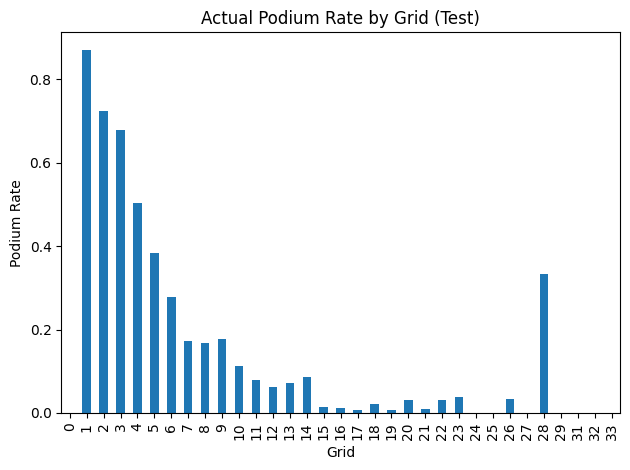

In [27]:
test = model_df.iloc[test_idx].copy(); test['pred'] = y_pred
rate = test.groupby('grid')['podium'].mean()
plt.figure(); rate.plot(kind='bar'); plt.title('Actual Podium Rate by Grid (Test)'); plt.xlabel('Grid'); plt.ylabel('Podium Rate')
plt.tight_layout()
plt.show()

### Notes / Learnings

In [28]:
# - 
# - 
# - 